<a href="https://colab.research.google.com/github/ernestoaddiego/FinanceMachineLearning/blob/master/StockPredictUsingML_EAG_06Sep19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Predictor using Machine Learning

*Resource:* https://www.datacamp.com/community/tutorials/finance-python-trading

**Intent** 

Demonstrating the application of python programming and machine learning techniques on stock predictions.

I modified the tutorial from [DataCamp](https://www.datacamp.com/community/tutorials/finance-python-trading) to do Exploratory Financial Analysis and build two trading strategies by using the latest YahooFinancials data module from [PyPI](https://pypi.org/project/yahoofinancials/)

**Outline**
- Importing Data
- Common Financial Analyses
- Building a Trading Strategy w. Python
  - Backtesting
  - Improving
  - Evaluating
- Implementing Other Machine Learning Algo Trading
  - Turtle Trading

First, I import the necessary packages we need.

In [0]:
# Import necessary packages
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

## Importing Data

A method to download data is to use the quoted `pandas_datareader` package and the `fix_yahoo_finance` as shown in the [DataCamp tutorial](https://www.datacamp.com/community/tutorials/finance-python-trading)

In [28]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

bp = pdr.get_data_yahoo('BP.L',
                         start=datetime.datetime(2010,6,1),
                         end=datetime.datetime(2019,8,31))
bp.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-01,446.350006,411.500000,440.0,430.000000,227283291.0,261.652039
2010-06-02,431.899994,415.100006,418.0,429.750000,123311927.0,261.499908
2010-06-03,450.049988,431.100006,440.0,432.250000,113817392.0,263.021118
2010-06-04,452.750000,432.500000,450.0,433.350006,98458965.0,263.690460
2010-06-07,448.000000,427.549988,430.0,430.299988,87928589.0,261.834534


*Note:* I selected this period as I know it reflects a period that this share price was rebalanced post the Deepwater Horizon accident.

## Working with Time Series Data

First, let's complete a few basic evaluation of the downloaded dataset. And plot a few key features.

In [29]:
# Sample 20 rows
sample = bp.sample(20)

# Print `sample`
print(sample)

# Resample to monthly level 
monthly_bp = bp.resample('M')

# Print `monthly_aapl`
print(monthly_bp)

                  High         Low  ...      Volume   Adj Close
Date                                ...                        
2018-06-11  590.000000  583.400024  ...  37748326.0  542.358826
2017-02-23  453.399994  447.829987  ...  35098875.0  385.959747
2015-01-27  445.679993  430.350006  ...  41562958.0  322.738373
2015-01-15  396.299988  376.700012  ...  55518121.0  287.578583
2013-11-26  490.750000  486.149994  ...  26248859.0  339.207123
2012-04-19  452.200012  440.049988  ...  20384138.0  281.103973
2018-01-09  529.400024  524.599976  ...  31258273.0  474.552063
2018-02-23  476.500000  468.799988  ...  29338300.0  434.464478
2016-01-18  347.350006  333.100006  ...  41699867.0  265.453888
2019-06-06  545.500000  540.000000  ...  25090931.0  532.481628
2013-07-08  462.450012  457.799988  ...  13554819.0  312.882904
2016-09-27  435.350006  426.299988  ...  22582020.0  354.153412
2016-07-05  453.799988  440.100006  ...  48388415.0  368.288208
2016-10-19  492.537994  485.700012  ... 

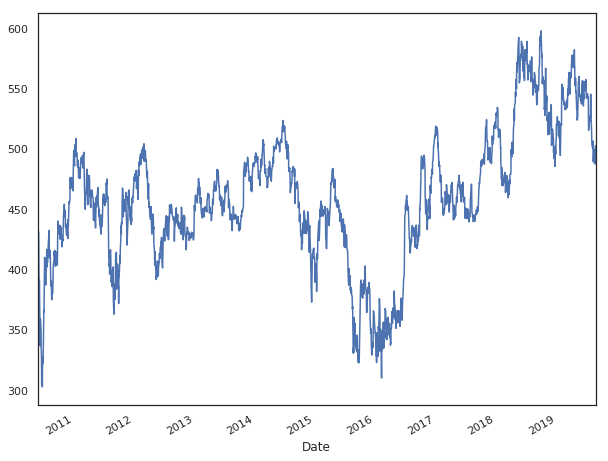

In [63]:
# Plot the closing prices for `bp`
bp['Close'].plot(grid=False, figsize=(10,8))

# Show the plot
plt.show()

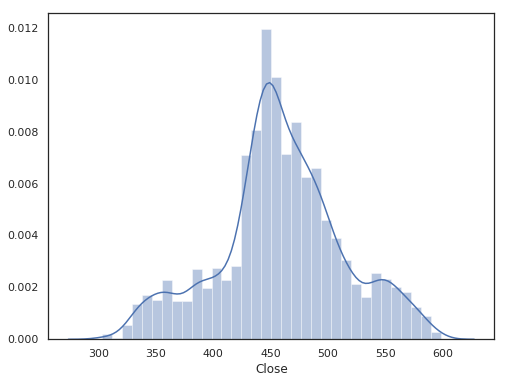

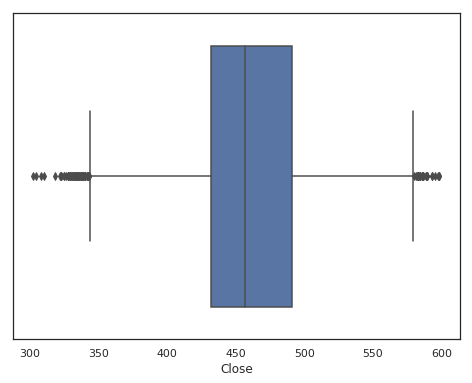

In [49]:
# then create a variable data w. data from column 'Close'
Close = bp['Close']

# a few styles formatting
sns.set(style="white")

# plot a distplot from seaborn
plt.figure(figsize=(8,6))
sns.distplot(Close)

# plot a boxplot from seaborn
plt.figure(figsize=(8,6))
sns.boxplot(Close)

*Reflection:* In its simplest form, I would program an algo trading to recommend to:
1. **Short/Sell** if the share price is greater than the mean+1Sigma.
2. **Hold** if the share price is within +/- a quartile from the mean.
3. **Long/Buy** if the share price is lower than the mean-1Sigma.

Finally, let's estimate a few more stats on the Close price.

In [50]:
# First, the mean
print ("\nMeans (pandas):\n")
print(Close.mean())

# then the sigma
print ("\nStd (pandas):\n")
print (Close.std())

# Estimating Min, Max, P10, P50, P90
print("\nMin (pandas):\n")
print(Close.min())

print("\nMax (pandas):\n")
print(Close.max())

print("\nP10 (pandas):\n")
print(Close.quantile(0.10))

print("\nP90 (pandas):n")
print(Close.quantile(0.90))


Means (pandas):

458.933581571685

Std (pandas):

54.91895413538307

Min (pandas):

302.8999938964844

Max (pandas):

598.2999877929688

P10 (pandas):

384.2799957275391

P90 (pandas):n
536.0299926757813


## Common Financial Analysis



In-depth analyses:
* Returns
  * Moving windows
* Correlations with peers
  * Volatility calculation


### Returns

Including:
* Daily returns
* Daily log returns
* Monthly % change
* Quaterly % change

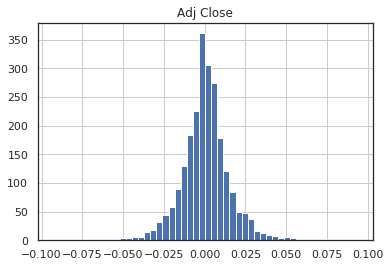

         Adj Close
count  2338.000000
mean      0.000388
std       0.014911
min      -0.093008
25%      -0.007252
50%       0.000115
75%       0.007634
max       0.093613


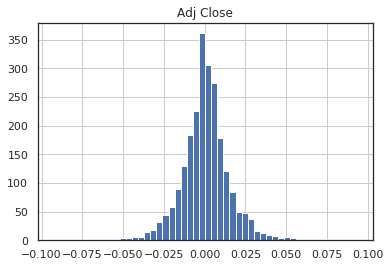

         Adj Close
count  2338.000000
mean      0.000388
std       0.014911
min      -0.093008
25%      -0.007252
50%       0.000115
75%       0.007634
max       0.093613


In [57]:
# Assign `Adj Close` to `daily_close`
daily_close = bp[['Adj Close']]

# Daily returns
daily_pct_c = daily_close.pct_change()

# Replace NA values with 0
daily_pct_c.fillna(0, inplace=True)

# Plot the distribution of `daily_pct_c`
daily_pct_c.hist(bins=50)

# Show the plot
plt.show()

# Pull up summary statistics
print(daily_pct_c.describe())

# Daily log returns
daily_log_returns = np.log(daily_close.pct_change()+1)

# Plot the distribution of `daily_log_returns`
daily_pct_c.hist(bins=50)

# Show the plot
plt.show()

# Pull up summary statistics
print(daily_pct_c.describe())

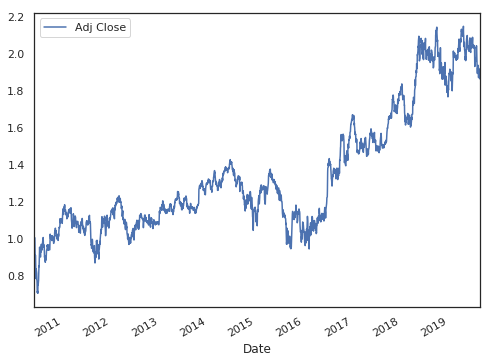

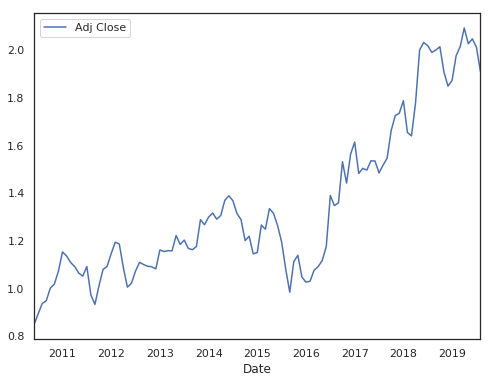

In [58]:
# Now compute the daily returns
# Calculate the cumulative daily returns
cum_daily_return = (1 + daily_pct_c).cumprod()

# Plot the cumulative daily returns
cum_daily_return.plot(figsize=(8,6))

# Show the plot
plt.show()

# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()

# Plot the cumulative daily returns
cum_monthly_return.plot(figsize=(8,6))

# Show the plot
plt.show()

#### Moving Average Windows

Considering two windows: short (ca. 42 days) and long (ca. 252 days)

*Self Note:* Here is another opportunity to build an auto algo trader. Key insight: compute the first derivatives of the long moving average. Actions when derivative is:
* Positive: *Long* stock. Capture extra gains with a short-stop.
* Zero/Inflexion point: prepare for next action... 
  * if derivative was >0 beforehand, then *Sell/Short* stock
  * if derivative was <0 beforehand, then *Buy/Long* stock
* Negative: *Short* stock.

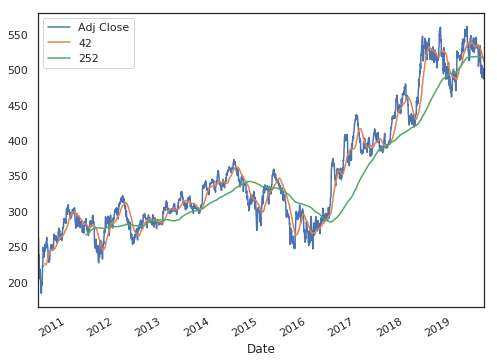

In [67]:
# Isolate the adjusted closing prices 
adj_close_px = bp['Adj Close']

# Short moving window rolling mean
bp['42'] = adj_close_px.rolling(window=40).mean()

# Long moving window rolling mean
bp['252'] = adj_close_px.rolling(window=252).mean()

# Plot the adjusted closing price, the short and long windows of rolling means
bp[['Adj Close', '42', '252']].plot(figsize=(8,6))

plt.show()

### Correlation versus the peers

Here we compare the stock of *bp* versus its peers (inclduding XOM, CVX, RDS, TOT)

In [59]:
def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['BP.L', 'RDSB.L', 'XOM', 'CVX','TOT']
all_data = get(tickers, datetime.datetime(2009, 1, 1), datetime.datetime(2019, 9, 1))
all_data.head()

High     Low    Open   Close      Volume   Adj Close
Ticker Date                                                              
BP.L   2009-01-02  553.50  524.50  532.75  552.75  25346686.0  308.958832
       2009-01-05  566.50  546.00  560.00  560.00  47203536.0  313.011200
       2009-01-06  565.00  550.00  560.00  554.50  49070574.0  309.936951
       2009-01-07  546.00  520.25  545.75  523.75  71650181.0  292.749268
       2009-01-08  533.75  515.00  518.00  532.00  36049644.0  297.360657

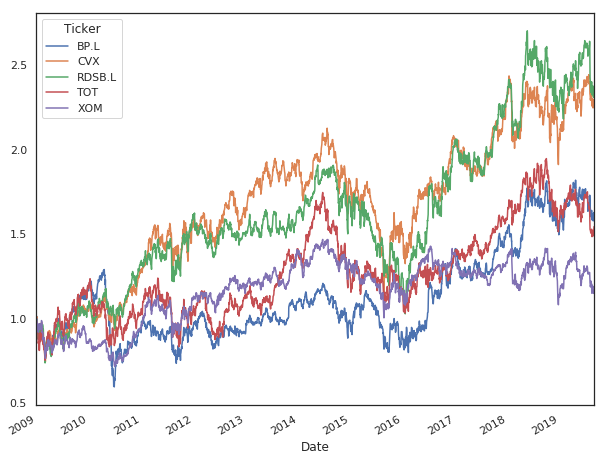

In [60]:
# estimate the daily close vectors
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date','Ticker','Adj Close')

# Estimate the daily percent change for 'daily_close_px'
daily_pct_change = daily_close_px.pct_change()

# estimate the cumulative daily returns
cum_daily_return_px = (1+daily_pct_change).cumprod()

# plot the price trends for all the peers
cum_daily_return_px.plot(figsize=(10,8))
plt.show()

Three clear groups - post oil recession in 2014 - 2016: 
* Winners: RDS & CVX
* Middle pack: BP & TOT
* Bottom pack: XOM

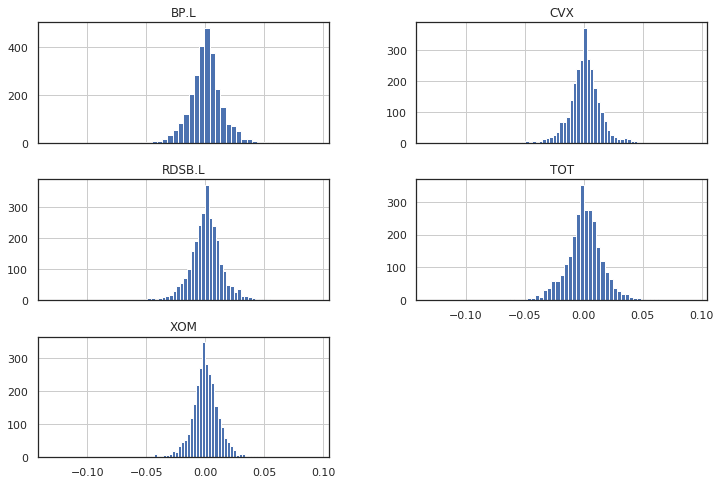

In [61]:
# Now show the distributions of the daily returns of each company stock
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))
plt.show()

The returns spread for these energy stocks are very similar.

XOM is an outlier: with negative mean return overall in the last 10 years.

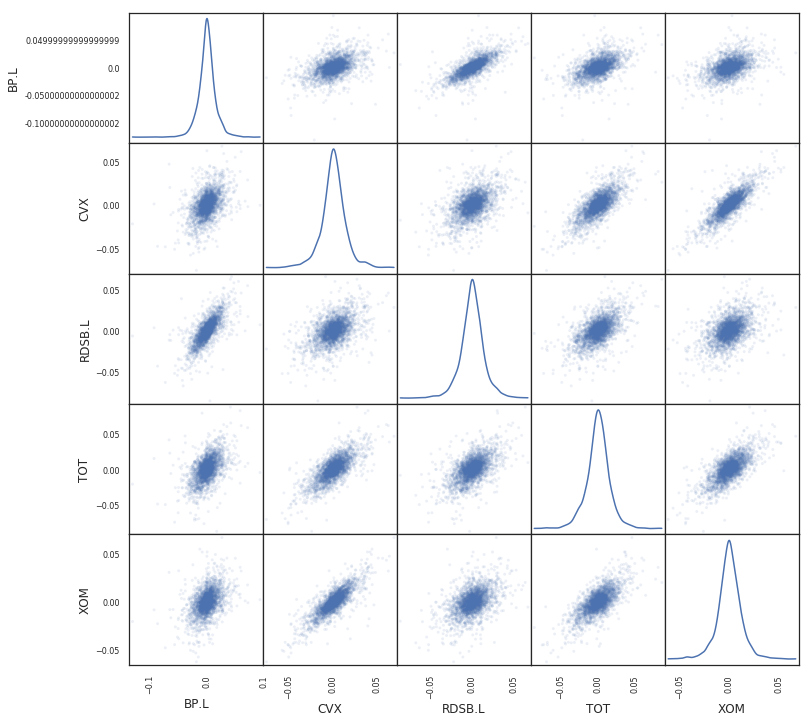

In [62]:
# And now show a scatter matrix that correlates the 'daily_pct_change' data
pd.plotting.scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(12,12))
plt.show()

#### Volatility Calculation
Using the standard deviation of each stock

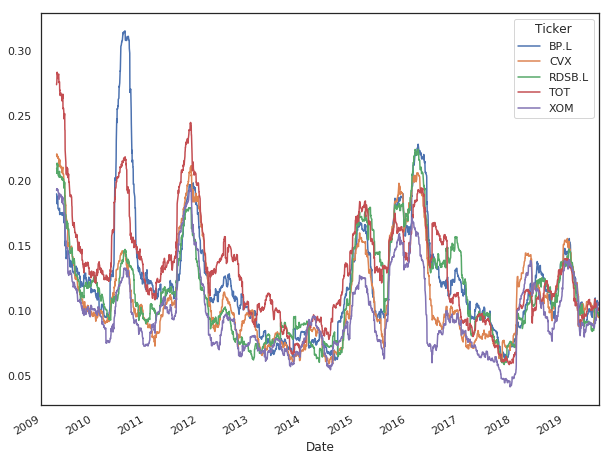

In [64]:
# Define the minumum of periods to consider 
min_periods = 75 

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(10, 8))

# Show the plot
plt.show()

The above plot shows how highly correlated the energy stocks are.

Few historical context:
* 2009: volatility high post-financial crisis
* 2010 2Q: Deepwater Horizon incident for BP
* 2012: Oil price above 100 usd/boe
* 2015 - 2017: oil price recession - rebasing to now 50 +/- 10 usd/boe

The next analyses will build a regression model between two end-members, namely: BP & RDS.

#### Ordinary Least-Square (OLS) Regression between two-pairs of stocks.

In [69]:
# Import the `api` model of `statsmodels` under alias `sm`
import statsmodels.api as sm
from pandas import tseries

# Isolate the adjusted closing price
all_adj_close = all_data[['Adj Close']]

# Calculate the returns 
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

# Isolate the BP.L returns 
bp_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'BP.L']
bp_returns.index = bp_returns.index.droplevel('Ticker')

# Isolate the RDSB.L returns
shell_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'RDSB.L']
shell_returns.index = shell_returns.index.droplevel('Ticker')

# Build up a new DataFrame with BP.L and RDSB.L returns
return_data = pd.concat([bp_returns, shell_returns], axis=1)[1:]
return_data.columns = ['BP.L', 'RDSB.L']

# Add a constant 
X = sm.add_constant(return_data['BP.L'])

# Construct the model
model = sm.OLS(return_data['RDSB.L'],X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 RDSB.L   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     2617.
Date:                Sat, 07 Sep 2019   Prob (F-statistic):               0.00
Time:                        02:59:21   Log-Likelihood:                 8541.7
No. Observations:                2693   AIC:                        -1.708e+04
Df Residuals:                    2691   BIC:                        -1.707e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.017      0.3

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


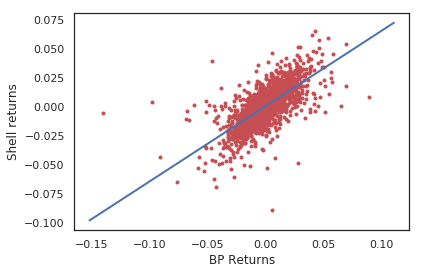

In [70]:
# A cross-plot showing the OLS regression between these two stocks
plt.plot(return_data['BP.L'], return_data['RDSB.L'], 'r.')

ax = plt.axis()
x = np.linspace(ax[0], ax[1] + 0.01)

plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw=2)

plt.grid(False)
plt.axis('tight')
plt.xlabel('BP Returns')
plt.ylabel('Shell returns')

plt.show()

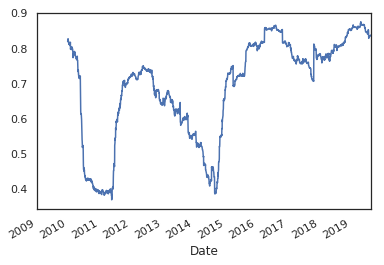

In [71]:
# And the correlation between these stocks over time...
return_data['RDSB.L'].rolling(window=252).corr(return_data['BP.L']).plot()
plt.show()

*Historical Context:*
Three marked periods include:
* 2010 2Q: BP's deepwater horizon incident. RDS & BP stock price diverge.
* 2012 - 2015: high oil price above 100 usd/boe. Stock pair prices start to diverge.
* 2015: Shell announces merger with BG Group. Paired stock price diverge.
* 2016 - 2019: stock prices highly correlated. Driven primarily by hydrocarbon pricing stability.

## Building A Trading Strategy with Python

This demo will develop the 'classic' trading strategy of the intersection between short and long moving averages.